In [24]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from gproc.elliptic import ess_samples_probit
from gproc.metropolis_hastings import mh, mh_step
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit, chol_inverse
from gproc.approx_marginal_is import importance_sampler

In [25]:
N = 50 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
y, prob_y, f = sample_at_x(x, kernel_fcn = squared_exponential, kernel_params = {'lengthscale': 1, 'variance': 3})

th_0 = np.array([1, 1])
gram = squared_exponential(x, x, lengthscale = th_0[0], variance = th_0[1])
inverse_gram = chol_inverse(gram)

In [26]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100)
marg_0

Converged: True


-17.000894816973826

In [49]:
def joint_sampler(iters, y, x, th_0, marg_0, cov, N_imp = 100, burn_in = 1, verbose = True):
    """
    Function that jointly samples from the posterior distribution over
    kernel parameters and the latent functions.

    Parameters
    ----------
    iters: float
        number of iterations of the joint sampling algorithm
        
    y: N dimensional numpy vector
        responses
    
    x: N x D dimensional numpy array
        covariates

    th_0: numpy vector
        initial kernel parameters

    marg_0: float
        initial approximation of the marginal
        
    cov: numpy array
        covariance matrix for use in the proposal distribution
        
    N_imp: float
        number of importance samples to use in marginal approximation
    
    burn_in: float
        number of burn in samples to use in ELL-SS
        
    verbose: boolean
        flag to produce loading bar

    Returns
    ----------
    f_arr: numpy array
        contains the latent function samples
        
    th_arr: numpy array
        contains the kernel parmams chains move history
    
    marg_arr: numpy array
        contains the history of marginal approximations
    
    acc_rate: float
        acceptance rate of moves
    """
    
    # Create array to hold samples and move history
    f_arr = np.zeros((iters, y.shape[0]))
    th_arr = np.zeros((iters + 1, th_0.shape[0]))
    marg_arr = np.zeros(iters + 1)
    move_arr = np.zeros(iters)
    
    # Add initialisation
    th_arr[0, :] = th_0
    marg_arr[0] = marg_0
    
    for i in tqdm(range(iters), disable=not(verbose)):
        # Get latent function sample corresponding to current kernel params
        K = squared_exponential(x, x, lengthscale = np.exp(th_arr[i, 0]), variance = np.exp(th_arr[i, 1]))
        K_chol = np.linalg.cholesky(K + 1e-05 * np.eye(K.shape[0]))
        f_arr[i, :] = ess_samples_probit(K_chol, y, 1, burn_in, verbose = False)
        
        # Get new kernel params
        th_arr[i + 1, :], marg_arr[i + 1], move_arr[i] = mh_step(y, x, th_arr[i, :], marg_arr[i], cov = cov, N_imp = N_imp)
    
    acc_rate = move_arr.mean()
    return f_arr, th_arr, marg_arr, acc_rate
        

In [50]:
f_arr, th_arr, marg_arr, acc_rate = joint_sampler(10000, y, x, th_0, marg_0, cov = np.eye(th_0.shape[0]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
acc_rate*100

5.86

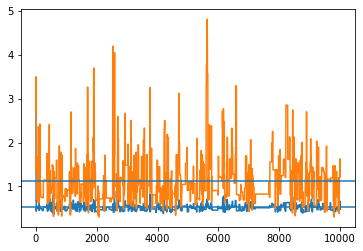

In [64]:
plt.plot(np.exp(th_arr[:, 0]))
plt.axhline(y =  np.mean(np.exp(th_arr[:, 0])))
plt.plot(np.exp(th_arr[:, 1]))
plt.axhline(y =  np.mean(np.exp(th_arr[:, 0])))
plt.show()

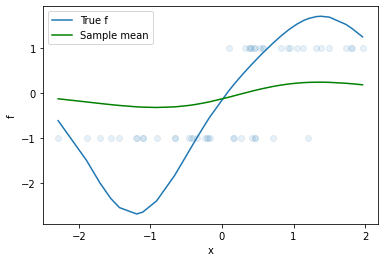

In [76]:
sort_ix = np.argsort(x.reshape(-1))
plt.scatter(x, y, alpha=0.1)
plt.xlabel('x')
plt.ylabel('f')
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr.mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.legend()
plt.show()

In [75]:
# Crap ^